In [1]:
import numpy as np
import dcTMD
from dcTMD.storing import WorkSet
from dcTMD.dcTMD import WorkEstimator
import dcTMD

The package is a Python implementation of the targeted molecular dynamics approach described in the paper "Targeted Molecular Dynamics Calculations of Free Energy Profiles Using a Nonequilibrium Friction Correction" by Steffen Wolf and Gerhard Stock. This approach provides a new method for calculating free energy profiles in molecular systems.

The package is designed to be used by researchers and practitioners in the fields of chemistry, biochemistry, and molecular biology. It is particularly useful for studying the dynamics and thermodynamics of complex molecular systems, such as proteins, nucleic acids, and membranes.

The package utilizes targeted molecular dynamics simulations to obtain free energy profiles. In this approach, a harmonic biasing potential is applied to a system to drive it along a reaction coordinate. The package includes a nonequilibrium friction correction that allows for more accurate calculation of free energy profiles by accounting for the dissipative effects of the solvent.

The implementation is efficient and flexible, allowing users to customize simulation parameters and easily analyze simulation results. The package also includes a variety of analysis tools for calculating thermodynamic quantities, visualizing simulation trajectories, and comparing results to experimental data.

Overall, the package provides a powerful tool for studying the thermodynamics and dynamics of molecular systems, and can aid in the design of new drugs and materials.

In [2]:
# define variables
velocity = 0.001
res = 1
verbose = True
temperature = 290


# create work set

load pullf files either with a file that contains the names of the pullf files and np.loadtxt() or the function dcTMD.io.load_pullf() which takes either a glob pattern or a file containing the pullf file names as argument.   

In [3]:
pullf_files = '../../tests/testdata/pullf_filenames.dat'
pullf_files = '../../tests/testdata/*pullf.xvg'
filenames = dcTMD.io.load_pullf(pullf_files)

filenames


file ../../tests/testdata/*pullf.xvg not found. using glob.glob(../../tests/testdata/*pullf.xvg)


['../../tests/testdata/t_middle_32_pullf.xvg',
 '../../tests/testdata/t_middle_03_pullf.xvg',
 '../../tests/testdata/t_middle_34_pullf.xvg',
 '../../tests/testdata/t_middle_24_pullf.xvg',
 '../../tests/testdata/t_middle_21_pullf.xvg',
 '../../tests/testdata/t_middle_04_pullf.xvg',
 '../../tests/testdata/t_middle_29_pullf.xvg',
 '../../tests/testdata/t_middle_16_pullf.xvg',
 '../../tests/testdata/t_middle_30_pullf.xvg',
 '../../tests/testdata/t_middle_19_pullf.xvg',
 '../../tests/testdata/t_middle_01_pullf.xvg',
 '../../tests/testdata/t_middle_28_pullf.xvg',
 '../../tests/testdata/t_middle_26_pullf.xvg',
 '../../tests/testdata/t_middle_31_pullf.xvg',
 '../../tests/testdata/t_middle_09_pullf.xvg',
 '../../tests/testdata/t_middle_17_pullf.xvg',
 '../../tests/testdata/t_middle_25_pullf.xvg',
 '../../tests/testdata/t_middle_05_pullf.xvg']

In [4]:
# create WorkSet instance
workset = WorkSet(velocity=velocity,
                  resolution=res,
                  verbose=False,
                  )
workset


WorkSet(velocity=0.001)

In [5]:
# fit/fill workset
workset.fit(filenames)
# save workset
#dcTMD.storing.save('my_workset', workset)
print(vars(workset))



Loading & integrating force files: 100%|██████████| 18/18 [00:00<00:00, 52.28it/s]

{'velocity': 0.001, 'resolution': 1, 'verbose': False, 'X': ['../../tests/testdata/t_middle_32_pullf.xvg', '../../tests/testdata/t_middle_03_pullf.xvg', '../../tests/testdata/t_middle_34_pullf.xvg', '../../tests/testdata/t_middle_24_pullf.xvg', '../../tests/testdata/t_middle_21_pullf.xvg', '../../tests/testdata/t_middle_04_pullf.xvg', '../../tests/testdata/t_middle_29_pullf.xvg', '../../tests/testdata/t_middle_16_pullf.xvg', '../../tests/testdata/t_middle_30_pullf.xvg', '../../tests/testdata/t_middle_19_pullf.xvg', '../../tests/testdata/t_middle_01_pullf.xvg', '../../tests/testdata/t_middle_28_pullf.xvg', '../../tests/testdata/t_middle_26_pullf.xvg', '../../tests/testdata/t_middle_31_pullf.xvg', '../../tests/testdata/t_middle_09_pullf.xvg', '../../tests/testdata/t_middle_17_pullf.xvg', '../../tests/testdata/t_middle_25_pullf.xvg', '../../tests/testdata/t_middle_05_pullf.xvg'], 'time_': array([0.0000e+00, 1.0000e-01, 2.0000e-01, ..., 1.9998e+03, 1.9999e+03,
       2.0000e+03]), 'work_':

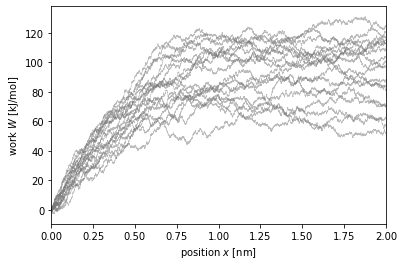

In [6]:
# plot workset
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x = workset.position_
for w in workset.work_:
        ax.plot(x, w, color='#777', alpha=.5, lw=.5)
        
ax.set(xlabel=r'position $x$ [nm]',
       ylabel=r'work $W$ [kJ/mol]',
       xlim=[min(x), max(x)],
)
plt.show()


shapiro wilkins results at x=0.05 is ShapiroResult(statistic=0.9363654255867004, pvalue=0.2508776783943176)
Kolmogorov-Smirnov results at x=0.05 is KstestResult(statistic=0.8848093538209025, pvalue=2.5548586381396563e-17)
shapiro wilkins results at x=0.1 is ShapiroResult(statistic=0.9850727915763855, pvalue=0.9871441721916199)
Kolmogorov-Smirnov results at x=0.1 is KstestResult(statistic=0.9999781317116784, pvalue=2.6163523873819675e-84)
shapiro wilkins results at x=0.15 is ShapiroResult(statistic=0.9645570516586304, pvalue=0.6913473010063171)
Kolmogorov-Smirnov results at x=0.15 is KstestResult(statistic=1.0, pvalue=0.0)


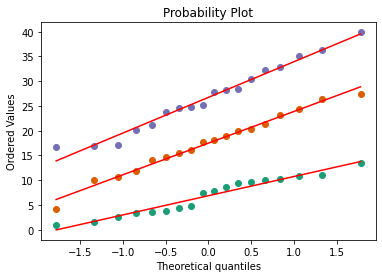

In [7]:
# check if work distribution follows a normal distribution
import math
import numpy as np
from scipy.stats import kstest, shapiro, probplot, norm
from matplotlib import cm

index = [500, 1000, 1500]

# do a probplot
fig, ax = plt.subplots()
cm_subsectionJ = np.linspace(0, 1, 7)
lcolor = [cm.Dark2(x) for x in cm_subsectionJ]
for i, p in enumerate(index):
    res = probplot(workset.work_[:,p], plot=ax, fit=True)
    ax.get_lines()[i*2].set_color(lcolor[i])
    # Shapiro-Wilk Test
    shapiro_test = shapiro(workset.work_[:,p])
    print(f'shapiro wilkins results at x={x[p]} is {shapiro_test}')
    # Kolmogorov-Smirnov Test
    kstest_test = kstest(workset.work_[:,p], 'norm')
    
    print(f'Kolmogorov-Smirnov results at x={x[p]} is {kstest_test}')

(8.26771653543307, 2.9133858267716533)
500
1000
1500


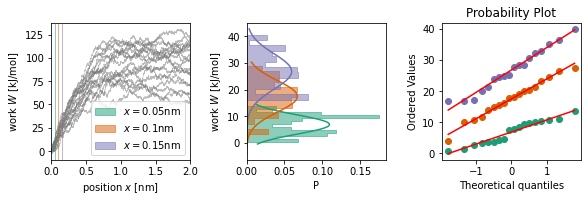

In [30]:
def fig_size():
    # Convert cm to inches
    fig_width_cm = 21                                         
    fig_height_cm = 14.8 / 2
    inches_per_cm = 1 / 2.54  
    # width in inches                                 
    fig_width = fig_width_cm * inches_per_cm  
    # height in inches                 
    fig_height = fig_height_cm * inches_per_cm                
    fig_size = (fig_width, fig_height)
    return fig_size


# add vertical lines and distribution
bins = 20
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=fig_size())

for w in workset.work_:
        axs[0].plot(x, w, color='#777', alpha=.5, lw=.5)
        
axs[0].set(xlabel=r'position $x$ [nm]',
       ylabel=r'work $W$ [kJ/mol]',
       xlim=[min(x), max(x)],
)

for j, idx in enumerate(index):
    print(idx)
    dist = workset.work_[:, idx-bins: idx+bins].flatten()
    x_dist = np.linspace(0, len(dist)-1, len(dist))
    #axs[1].step(x_dist, dist, where='mid', color=lcolor[j])
    axs[1].hist(dist, bins='doane',
                density=True,
                histtype='stepfilled',
                align='mid',
                alpha=0.5,
                orientation='horizontal',
                color=lcolor[j],
                label=rf'$x={x[idx]}$nm',
                ec=lcolor[j],
                )
    mu, std = norm.fit(dist)
    # Plot the PDF.
    ymin, ymax = axs[1].get_ylim()
    y = np.linspace(ymin, ymax, 100)
    p = norm.pdf(y, mu, std)
    axs[1].plot(p, y, color=lcolor[j])
    axs[1].set(xlabel=r'position $x$ [nm]',
               ylabel=r'work $W$ [kJ/mol]',
               )
    #title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    axs[0].axvspan(x[idx-bins],
                   x[idx+bins],
                   color=lcolor[j],
                   alpha=0.5,
                   zorder=3,
                   label=rf'$x={x[idx]}$nm',
                   )
    
    res = probplot(workset.work_[:,idx], plot=axs[2], fit=True)
    axs[2].get_lines()[j*2].set_color(lcolor[j])
    
axs[0].legend()
axs[1].set(xlabel=r'P')

plt.tight_layout()

In [ ]:
# create WorkEstimator instance
workestimator = WorkEstimator(temperature)
# fit existing workset
# or load an existing workset
# workset = dcTMD.storing.load(my_workset)
workestimator.fit(workset)
vars(workestimator)

# smooth friction
from dcTMD.utils.smoothing import gaussfilter_friction
smooth_friction_ = gaussfilter_friction(workestimator.friction_,
                                        x,
                                        0.1,
                                        )

{'temperature': 290,
 'verbose': False,
 'work_set': WorkSet(resolution=10, velocity=0.001),
 'W_mean_': array([ 0.        ,  0.14466391,  0.36114316, ..., 93.12437156,
        93.16217564, 93.25164019]),
 'W_diss_': array([0.00000000e+00, 2.10598947e-02, 6.23645266e-02, ...,
        1.05549583e+02, 1.06622342e+02, 1.06653346e+02]),
 'dG_': array([  0.        ,   0.12360401,   0.29877864, ..., -12.42521181,
        -13.46016651, -13.4017057 ]),
 'friction_': array([      0.        ,   21059.89470551,   41304.63188297, ...,
        1487057.3383258 , 1072758.78472151,   31003.73802612])}

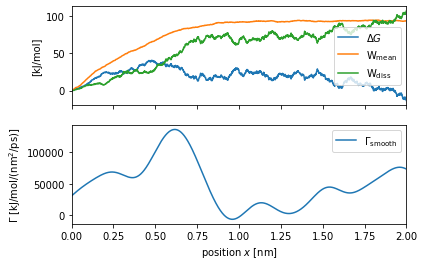

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True)
x = workset.position_
ax = axs[0]
ax.plot(x, workestimator.dG_, label=r'$\Delta G$')
ax.plot(x, workestimator.W_mean_, label=r'W$_{\mathrm{mean}}$')
ax.plot(x, workestimator.W_diss_, label=r'W$_{\mathrm{diss}}$')

ax.set(ylabel=r'[kJ/mol]',
       xlim=[min(x), max(x)],
)
ax.legend()
ax = axs[1]
#ax.plot(x, workestimator.friction_, label=r"$\Gamma$")
ax.plot(x, smooth_friction_, label=r"$\Gamma_{\mathrm{smooth}}$")

ax.set(xlabel=r'position $x$ [nm]',
       ylabel=r'$\Gamma$ [kJ/mol/(nm$^2$/ps)]',
       xlim=[min(x), max(x)],
)
ax.legend()
plt.show()